In [1]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
tasks = 12
epochs = 100
learning_rate = 1e-3
batch_size = 64
on_colab = False
divide_tasks = False

category={0: 'boxingmoving', 
          1: 'boxingstill', 
          2: 'crawling', 
          3: 'running', 
          4: 'still', 
          5: 'walking', 
          6: 'walkinglow'}

cuda_available = False
if torch.cuda.is_available():
    cuda_available = True

dt = datetime.datetime.now()

### Get data

In [3]:
### Data: (# of subject, # of classes, # of data, width, height)
if divide_tasks:
    train_data = []
    test_data = []

    for task in range(1, tasks+1):
        if on_colab:
            data_path = 'drive/My Drive/projects/data/RADAR/Subject%d'%(task)
        else:
            data_path = './data/RADAR/Subject%d'%(task)

        train_data_per_task = []
        test_data_per_task = []
        for _, cat in category.items():
            # train data
            train_data_per_cat = []
            test_data_per_cat = []

            for i in range(1, 10):
                filename = 'Human_Spect_test%d_%s_0%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'train', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                train_data_per_cat.append(img)

            # test data
            for i in range(10, 13):
                filename = 'Human_Spect_test%d_%s_%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'test', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                test_data_per_cat.append(img)

            
            train_data_per_task.append(train_data_per_cat)
            test_data_per_task.append(test_data_per_cat)
            
        train_data.append(train_data_per_task)
        test_data.append(test_data_per_task)
        

    train_data = torch.Tensor(train_data)
    test_data = torch.Tensor(test_data)

    if cuda_available:
        train_data = train_data.cuda()
        test_data = test_data.cuda()

    print(train_data.shape)
    print(test_data.shape)

    train_labels = np.zeros((9, ))
    test_labels = np.zeros((3, ))

    for i in range(1, 7):
        train_labels = np.vstack((train_labels, np.zeros((9, )) + i))
        test_labels = np.vstack((test_labels, np.zeros((3, )) + i))

    train_labels = torch.Tensor(train_labels).type(torch.LongTensor)
    test_labels = torch.Tensor(test_labels).type(torch.LongTensor)

    if cuda_available:
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print(train_labels.shape)
    print(test_labels.shape)

In [4]:
if not divide_tasks:
    train_data = torch.empty((7, 108, 128, 128))
    test_data = torch.empty((7, 36, 128, 128))

    for task in range(1, tasks+1):
        if on_colab:
            data_path = 'drive/My Drive/projects/data/RADAR/Subject%d'%(task)
        else:
            data_path = './data/RADAR/Subject%d'%(task)

        for cat_i, cat in category.items():
            # train data
            for i in range(1, 10):
                filename = 'Human_Spect_test%d_%s_0%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'train', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                train_data[cat_i, (task - 1) * 9 + (i - 1)] = torch.Tensor(img)

            # test data
            for i in range(10, 13):
                filename = 'Human_Spect_test%d_%s_%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'test', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                test_data[cat_i, (task - 1) * 3 + (i - 10)] = torch.tensor(img)

    if cuda_available:
        train_data = train_data.cuda()
        test_data = test_data.cuda()

    print(train_data.shape)
    print(test_data.shape)
    
    train_labels = np.zeros((9*12, ))
    test_labels = np.zeros((3*12, ))

    for i in range(1, 7):
        train_labels = np.vstack((train_labels, np.zeros((9*12, )) + i))
        test_labels = np.vstack((test_labels, np.zeros((3*12, )) + i))

    train_labels = torch.Tensor(train_labels).type(torch.LongTensor)
    test_labels = torch.Tensor(test_labels).type(torch.LongTensor)

    if cuda_available:
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print(train_labels.shape)
    print(test_labels.shape)

torch.Size([7, 108, 128, 128])
torch.Size([7, 36, 128, 128])
torch.Size([7, 108])
torch.Size([7, 36])


In [6]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv_module = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, 5, 1), # 6 @ 124*124
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # 6 @ 62*62
            torch.nn.Conv2d(6, 16, 7, 1), # 16 @ 56*56
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # 16 @ 28*28
            # Conv 추가
            torch.nn.Conv2d(16, 16, 5, 1), # 16 @ 24*24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2) # 16 @ 12*12
        )

        self.fc_module = torch.nn.Sequential(
            torch.nn.Linear(16*12*12, 128),
            torch.nn.ReLU(),
            #Linear 빼고
            #dropout 추가
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(128, 7)
        )

        if torch.cuda.is_available():
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()

    def forward(self, input):
        x = self.conv_module(input)
        dim = x.shape[1] * x.shape[2] * x.shape[3]
        x = x.view(-1, dim)
        return self.fc_module(x)

### Training & Validation

In [8]:
print(train_data.shape)
print(train_labels.shape)

torch.Size([7, 108, 128, 128])
torch.Size([7, 108])


In [12]:
net = NeuralNet()
if cuda_available:
    net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

logfile_name = "logfile_training_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
log_file = open(logfile_name, "w")

running_loss = 0
avg_acc = {}

net.train()
num_class, num_data, _, __ = train_data.shape
for i in range(5):
    for epoch in range(epochs):
    #     for key, _ in category.items():
        seed = torch.randperm(num_class * num_data)
        _train_data = train_data.view(-1, 1, 128, 128)[seed]
        _train_label = train_labels.view(-1)[seed]

        net.zero_grad()
        optimizer.zero_grad()

        outputs = net(_train_data)
        loss = criterion(outputs, _train_label)

        loss.backward()
        optimizer.step()

        running_loss += loss.data.item()

        if epoch % 50 == 49:
            msg = 'Epoch: %d, AVG. loss: %.3f\n'% (epoch + 1, running_loss)
            print(msg)
            log_file.write(msg)
            running_loss = 0

    total = 0
    correct = 0
    net.eval()
    for key, _ in category.items():
        _test_data = test_data[key].view(3*12, 1, 128, 128)
        output = net(_test_data)
        _, predicted = torch.max(output.data, dim=1)
        total += test_labels[key].shape[0]
        correct += (predicted == test_labels[key]).sum()

    acc = correct.cpu().numpy()*100/total
    msg = 'Average accuracy %d %%\n' % (acc)
    print(msg)
    log_file.write(msg)
log_file.close()

Epoch: 50, AVG. loss: 62.599

Epoch: 100, AVG. loss: 3.647

Average accuracy 92 %

Epoch: 50, AVG. loss: 0.112

Epoch: 100, AVG. loss: 0.028

Average accuracy 92 %

Epoch: 50, AVG. loss: 0.016

Epoch: 100, AVG. loss: 0.011

Average accuracy 92 %

Epoch: 50, AVG. loss: 0.008

Epoch: 100, AVG. loss: 0.006

Average accuracy 92 %

Epoch: 50, AVG. loss: 0.005

Epoch: 100, AVG. loss: 0.004

Average accuracy 92 %



### Plot

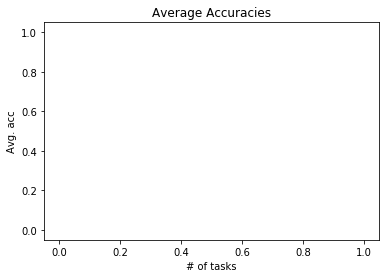

In [11]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies")

x, y = list(avg_acc.keys()), list(avg_acc.values())
plt.plot(x, y)

plt.show()